## Final Project: Notebook

In [3]:
import scipy as sp
import numpy as np
import pandas as pd
import json
from sklearn import cross_validation
from sklearn import grid_search
from sklearn import ensemble
from sklearn import metrics

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid", font_scale=1.5)
%matplotlib inline

## Acquire the Data

In [4]:
# The original train dataset is 37M rows
# Will sample it down to 1 percent so I am able to process it on my computer
from dask import dataframe
from dask.diagnostics import ProgressBar

In [5]:
dd = dataframe.read_csv('train/train.csv/train.csv', blocksize=100000000)

In [6]:
with ProgressBar():
    data = dd.sample(.01).compute()

[########################################] | 100% Completed |  3min 16.9s


In [7]:
#Preview the dataset
pd.DataFrame(data).head()

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
162685,2014-07-23 08:41:08,2,3,66,442,47956,1192.1126,614194,0,1,...,0.0,1.0,8287.0,1.0,1.0,1.0,2.0,198.0,397.0,55.0
782512,2014-12-04 11:00:53,11,3,205,354,55763,33.4043,196587,0,0,...,0.0,1.0,4474.0,3.0,0.0,1.0,2.0,198.0,397.0,19.0
339113,2014-06-10 12:27:38,37,1,69,990,12811,NaN,1167705,0,0,...,0.0,1.0,12267.0,6.0,0.0,1.0,2.0,50.0,1230.0,83.0
99462,2014-09-01 09:50:53,2,3,66,363,51253,7863.2806,388180,0,0,...,0.0,1.0,1795.0,1.0,0.0,1.0,3.0,99.0,1312.0,67.0
674015,2014-04-15 16:30:22,37,1,69,560,4288,NaN,1043120,0,0,...,0.0,3.0,3404.0,6.0,0.0,1.0,6.0,70.0,306.0,75.0


## Parse, Mine, and Refine the data

In [8]:
print data.shape

(376707, 24)


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 376707 entries, 162685 to 132628
Data columns (total 24 columns):
date_time                    376707 non-null object
site_name                    376707 non-null int64
posa_continent               376707 non-null int64
user_location_country        376707 non-null int64
user_location_region         376707 non-null int64
user_location_city           376707 non-null int64
orig_destination_distance    241877 non-null float64
user_id                      376707 non-null int64
is_mobile                    376707 non-null int64
is_package                   376707 non-null int64
channel                      376707 non-null int64
srch_ci                      376242 non-null object
srch_co                      376242 non-null object
srch_adults_cnt              376707 non-null float64
srch_children_cnt            376707 non-null float64
srch_rm_cnt                  376707 non-null float64
srch_destination_id          376707 non-null float64
srch

In [10]:
data.columns

Index([u'date_time', u'site_name', u'posa_continent', u'user_location_country',
       u'user_location_region', u'user_location_city',
       u'orig_destination_distance', u'user_id', u'is_mobile', u'is_package',
       u'channel', u'srch_ci', u'srch_co', u'srch_adults_cnt',
       u'srch_children_cnt', u'srch_rm_cnt', u'srch_destination_id',
       u'srch_destination_type_id', u'is_booking', u'cnt', u'hotel_continent',
       u'hotel_country', u'hotel_market', u'hotel_cluster'],
      dtype='object')

In [11]:
#Check for missing values; looks like origin to destination distance, check in and check out dates have missing values
data.isnull().sum()

date_time                         0
site_name                         0
posa_continent                    0
user_location_country             0
user_location_region              0
user_location_city                0
orig_destination_distance    134830
user_id                           0
is_mobile                         0
is_package                        0
channel                           0
srch_ci                         465
srch_co                         465
srch_adults_cnt                   0
srch_children_cnt                 0
srch_rm_cnt                       0
srch_destination_id               0
srch_destination_type_id          0
is_booking                        0
cnt                               0
hotel_continent                   0
hotel_country                     0
hotel_market                      0
hotel_cluster                     0
dtype: int64

### Create first version of dataframe

In [12]:
# I decided to create two versions of the dataset: one will add the bookings window and length of stay colums, 
# the second one will keep the distance column.
# Drop columns, keep the search check out column and drop the half empty distance column
df2= data.drop(['user_id','srch_adults_cnt','srch_rm_cnt', 'cnt','site_name', 'orig_destination_distance'], axis=1)

In [13]:
#Drop missing values
df2 = df2.dropna(axis=0,subset=['srch_ci','srch_co'])

In [14]:
#convert check in date column into datetime format
df2['srch_ci'] = pd.to_datetime(df2['srch_ci'],format='%Y-%m-%d')

In [15]:
#convert check out date column into datetime format
df2['srch_co'] = pd.to_datetime(df2['srch_co'],format='%Y-%m-%d')

In [16]:
#convert date_time column into datetime format
df2['date_time'] = pd.to_datetime(df2['date_time'],format='%Y-%m-%d')

In [17]:
# create new column with booking window calculation
df2['bw'] = df2['srch_ci']-df2['date_time']

In [18]:
# create new column with length of stay calculation
df2['LOS'] = df2['srch_co']-df2['srch_ci']

In [19]:
# check new columns
df2.head()

,date_time,posa_continent,user_location_country,user_location_region,user_location_city,is_mobile,is_package,channel,srch_ci,srch_co,srch_children_cnt,srch_destination_id,srch_destination_type_id,is_booking,hotel_continent,hotel_country,hotel_market,hotel_cluster,bw,LOS
162685,2014-07-23 08:41:08,3,66,442,47956,0,1,9,2014-09-25,2014-09-28,0.0,8287.0,1.0,1.0,2.0,198.0,397.0,55.0,63 days 15:18:52,3 days
782512,2014-12-04 11:00:53,3,205,354,55763,0,0,5,2014-12-24,2014-12-25,0.0,4474.0,3.0,0.0,2.0,198.0,397.0,19.0,19 days 12:59:07,1 days
339113,2014-06-10 12:27:38,1,69,990,12811,0,0,9,2014-06-16,2014-06-20,0.0,12267.0,6.0,0.0,2.0,50.0,1230.0,83.0,5 days 11:32:22,4 days
99462,2014-09-01 09:50:53,3,66,363,51253,0,0,9,2014-09-13,2014-09-14,0.0,1795.0,1.0,0.0,3.0,99.0,1312.0,67.0,11 days 14:09:07,1 days
674015,2014-04-15 16:30:22,1,69,560,4288,0,0,5,2014-06-16,2014-06-20,0.0,3404.0,6.0,0.0,6.0,70.0,306.0,75.0,61 days 07:29:38,4 days


In [20]:
# convert to number format booking window and length of stay columns
df2.bw.dt.days.head()

162685    63
782512    19
339113     5
99462     11
674015    61
Name: bw, dtype: int64

In [21]:
df2['bw']=df2.bw.dt.days

In [22]:
df2['LOS']=df2.LOS.dt.days

### Create second dataframe

In [24]:
# Drop unnecessary columns
df1 = data.drop(['user_id','srch_co','srch_adults_cnt','srch_rm_cnt', 'cnt','site_name',], axis=1)

In [25]:
#Drop missing values
df1 = df1.dropna(axis=0,subset=['srch_ci','orig_destination_distance'])

In [26]:
#check for missing values again
df1.isnull().sum().sum()

0L

In [27]:
df1.shape

(241605, 18)

## Perform exploratory data analysis

In [28]:
# Dataset statistics
df1.describe()

,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,is_mobile,is_package,channel,srch_children_cnt,srch_destination_id,srch_destination_type_id,is_booking,hotel_continent,hotel_country,hotel_market,hotel_cluster
count,241605.000000,241605.00000,241605.000000,241605.000000,241605.000000,241605.000000,241605.000000,241605.000000,241605.000000,241605.000000,241605.000000,241605.000000,241605.000000,241605.000000,241605.000000,241605.000000
mean,2.902887,87.78750,311.813236,28108.869233,1968.588822,0.136036,0.244246,6.007674,0.352083,14377.571118,2.624035,0.082436,2.891567,73.986975,621.067296,49.788891
std,0.539105,54.48369,144.740950,16569.024768,2230.313580,0.342828,0.429640,3.728256,0.757640,10779.470828,2.165187,0.275029,1.496237,53.495520,475.599103,29.139832
min,0.000000,0.00000,135.000000,0.000000,0.005600,0.000000,0.000000,0.000000,0.000000,4.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,66.00000,174.000000,14656.000000,311.800700,0.000000,0.000000,2.000000,0.000000,8267.000000,1.000000,0.000000,2.000000,50.000000,245.000000,25.000000
50%,3.000000,66.00000,321.000000,27655.000000,1138.178000,0.000000,0.000000,9.000000,0.000000,11319.000000,1.000000,0.000000,2.000000,50.000000,628.000000,48.000000
75%,3.000000,66.00000,363.000000,43175.000000,2554.396100,0.000000,0.000000,9.000000,0.000000,17859.000000,5.000000,0.000000,4.000000,77.000000,701.000000,73.000000
max,4.000000,215.00000,1021.000000,56507.000000,11794.745400,1.000000,1.000000,10.000000,9.000000,65047.000000,9.000000,1.000000,6.000000,212.000000,2117.000000,99.000000


0.136036091968


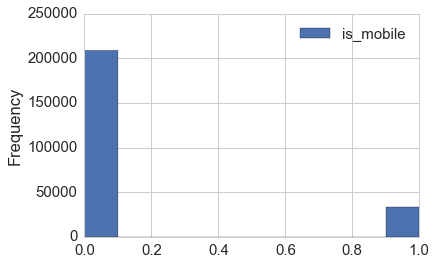

In [29]:
# Of all inqueires how many were connected via mobile device. Looks like only about 13 percent of all inqueries
# searched via mobile device
df1[['is_mobile']].plot(kind='hist')

print df1['is_mobile'].mean()

In [32]:
# 13 per cent accounted for 32867 mobile inqueries
df1['is_mobile'].value_counts()

0    208738
1     32867
Name: is_mobile, dtype: int64

In [30]:
# Get group by counts for bookings by is_mobile
df_by_mobile = pd.DataFrame()
df_by_mobile['mobile'] = df1[df1['is_mobile']==1]['is_booking'].value_counts(normalize=True)
df_by_mobile['other'] = df1[df1['is_mobile']==0]['is_booking'].value_counts(normalize=True)


0.102374855651


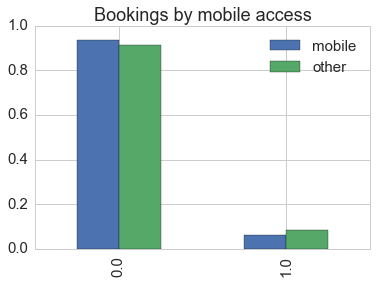

In [31]:
# Of all inquiries plot bookings and connection via mobile device
# Normalized data shows that compared to desktop searches, mobile  booking rate was lower
df_by_mobile.plot(kind='bar', title="Bookings by mobile access")
print df1[df1['is_booking']==1]['is_mobile'].mean()

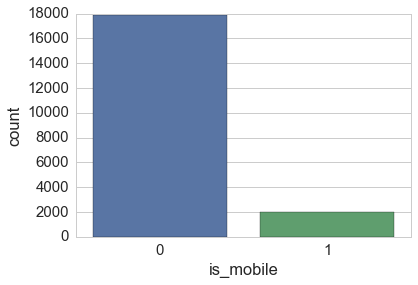

In [33]:
# of all mobile inqueiries how many resulted in a booking
sns.countplot('is_mobile',data=df1[df1['is_booking']==1])

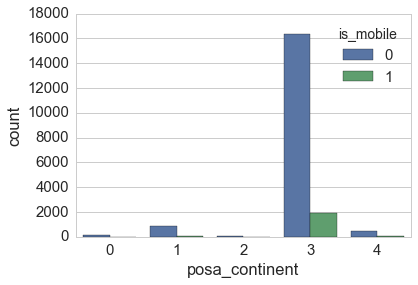

In [34]:
# All bookings by user continent and mobile access
# Users from continent 3 have more bookings both via mobile and desktop devices compared to other continents
sns.countplot('posa_continent', data=df1[df1['is_booking']==1], hue='is_mobile')

In [35]:
# subset inqueries that resulted in a booking
bookings = df1[df1['is_booking']==1]

In [36]:
# subset data that was accessed through mobile device
mobile = df1[df1['is_mobile']==1]

In [37]:
bookings.shape

(19917, 18)

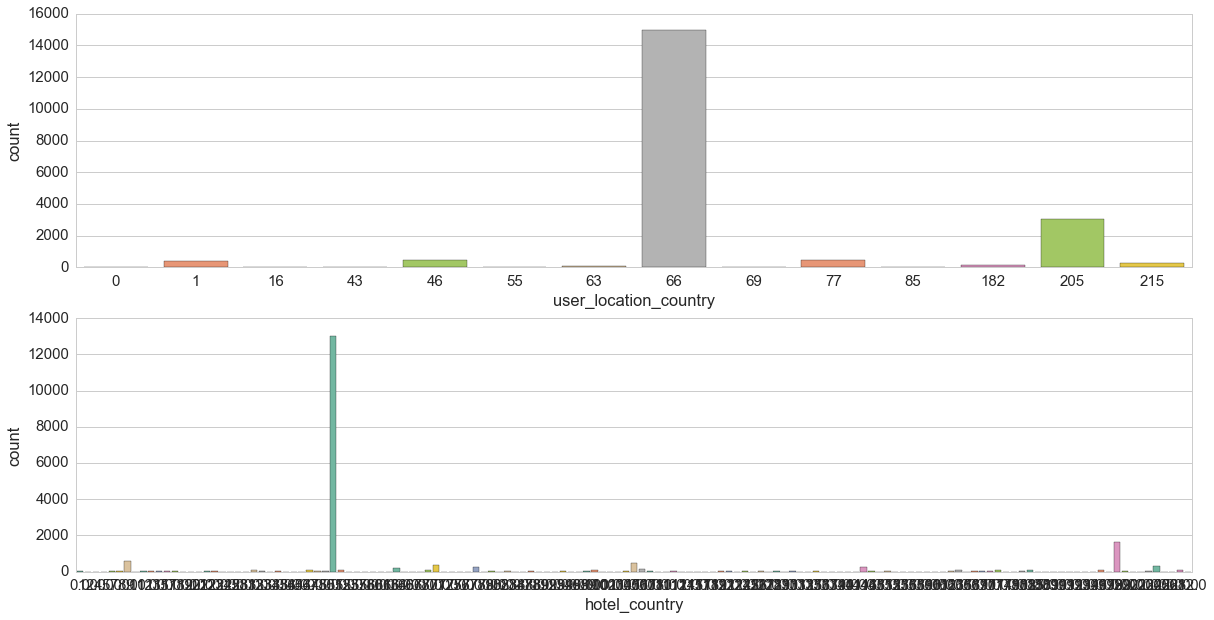

In [38]:
# Plot bookings by user location country and by hotel country
# Users from country id 66 book the most
fig, (axis1,axis2) = plt.subplots(2,1,figsize=(20,10))
sns.countplot('user_location_country', data=bookings, ax=axis1,palette="Set2")
sns.countplot('hotel_country',data=bookings,ax=axis2, palette="Set2")

In [39]:
# Top 5 contries with most booked hotels
bookings.hotel_country.value_counts()[:5,]

50.0     13002
198.0     1668
8.0        604
105.0      506
70.0       370
Name: hotel_country, dtype: int64

In [40]:
# Top 5 contries with most searched hotels
df1.hotel_country.value_counts()[:5,]

50.0     141060
8.0       15208
198.0     14232
105.0      7505
70.0       5281
Name: hotel_country, dtype: int64

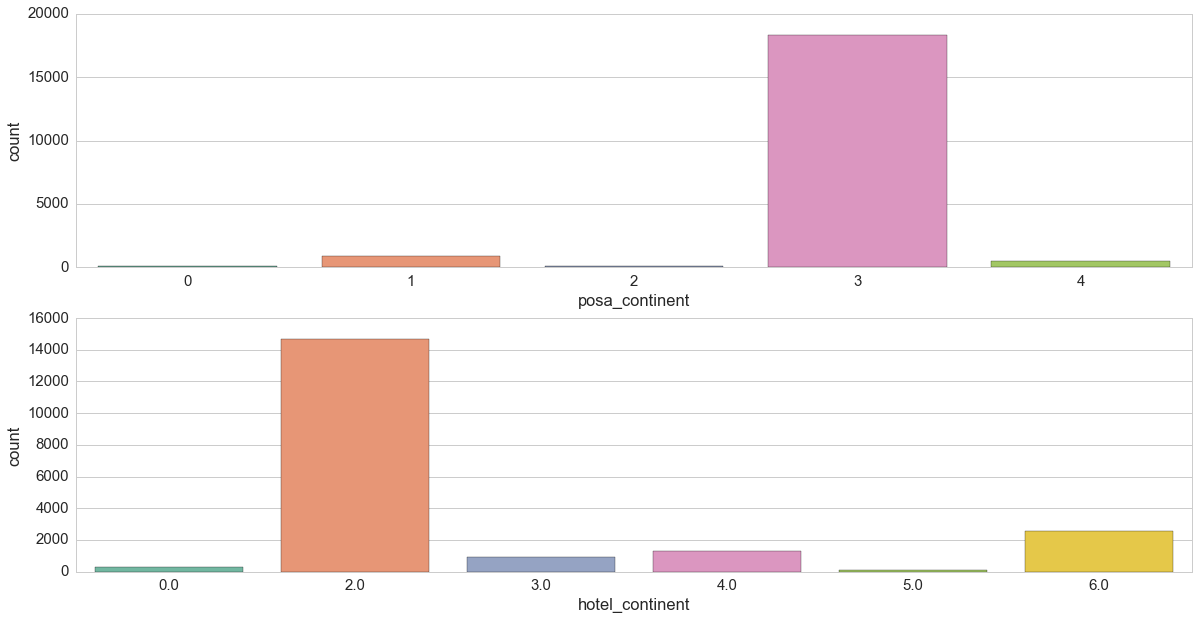

In [41]:
# Compare bookings from user continent and hotel continent
# Again users from continent 3 (probably North America) book the most, and hotels on continent number 2 are the most booked.
fig, (axis1,axis2) = plt.subplots(2,1,figsize=(20,10))
sns.countplot('posa_continent', data=bookings, ax=axis1,palette="Set2")
sns.countplot('hotel_continent',data=bookings,ax=axis2, palette="Set2")

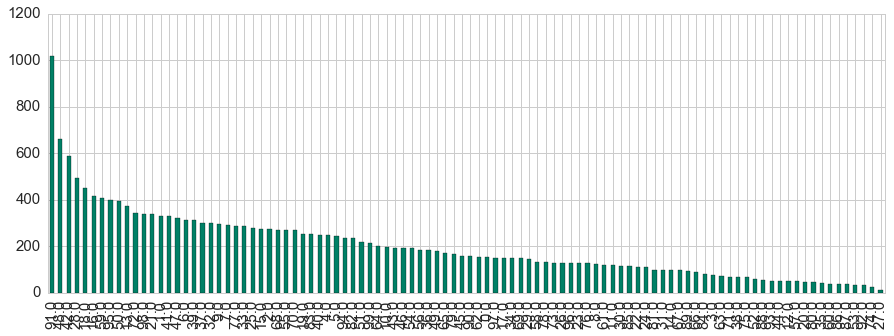

In [42]:
# Plot booked hotel clusters
bookings["hotel_cluster"].value_counts().plot(kind='bar',figsize=(15,5),cmap='summer')

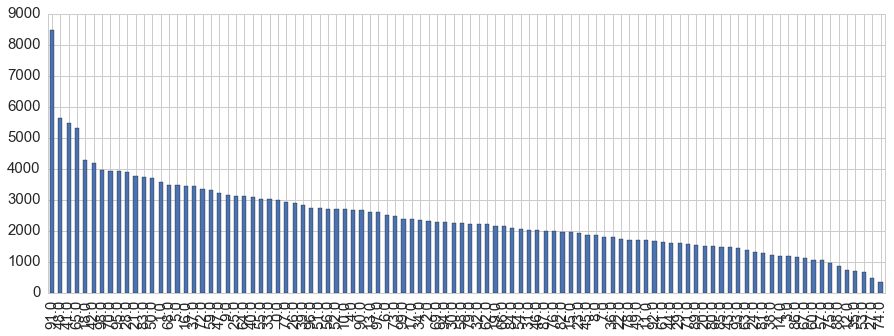

In [43]:
# Plot all searched hotel clusters
df1["hotel_cluster"].value_counts().plot(kind='bar', figsize=(15,5))

In [44]:
# Look for top 5 most searched and most booked hotel clusters. 3 out of 5 hotel clusters are most booked and searched.
# Not all hotel clusters that are in most searched appear in the top 5 for searched via mobile device -- can explore more.
print "Top 5 searched hotel clusters" 
df1.hotel_cluster.value_counts()[:5,]


Top 5 searched hotel clusters


91.0    8481
48.0    5646
41.0    5456
65.0    5305
18.0    4270
Name: hotel_cluster, dtype: int64

In [45]:
print "Top 5 booked hotel clusters" 
bookings.hotel_cluster.value_counts()[:5,]

Top 5 booked hotel clusters


91.0    1018
48.0     659
42.0     586
28.0     493
18.0     450
Name: hotel_cluster, dtype: int64

In [43]:
print "Top 5 searched hotel clusters via mobile device"
mobile.hotel_cluster.value_counts()[:5,]

Top 5 searched hotel clusters via mobile device


91.0    1171
65.0     976
41.0     799
48.0     769
42.0     584
Name: hotel_cluster, dtype: int64

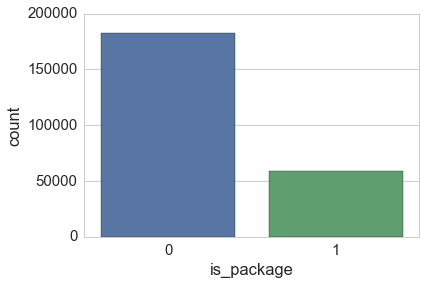

In [46]:
#How many inquries were for a package
sns.countplot('is_package',data=df1)

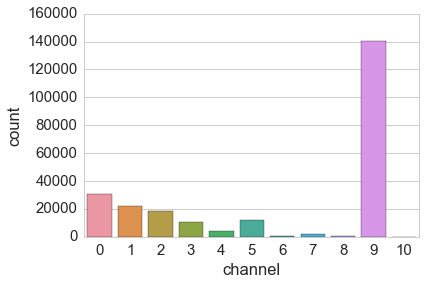

In [47]:
# Most popular channel number 9
sns.countplot('channel', data=df1)

In [ ]:
sns.lmplot(x='orig_destination_distance', y='is_booking', data=df1)

In [49]:
#convert check in date column into datetime format
df1['srch_ci'] = pd.to_datetime(df1['srch_ci'],format='%Y-%m-%d')

In [50]:
df1.srch_ci.head()

162685   2014-09-25
782512   2014-12-24
99462    2014-09-13
78166    2013-10-17
708064   2014-11-14
Name: srch_ci, dtype: datetime64[ns]

In [52]:
#convert date_time  column into datetime format
df1['date_time'] = pd.to_datetime(df1['date_time'])

In [53]:
df1.date_time.head()

162685   2014-07-23 08:41:08
782512   2014-12-04 11:00:53
99462    2014-09-01 09:50:53
78166    2013-10-17 09:59:58
708064   2014-02-18 11:06:09
Name: date_time, dtype: datetime64[ns]

In [54]:
# reindex to check in date
df1.set_index('srch_ci', inplace=True)

In [55]:
df1.index

DatetimeIndex(['2014-09-25', '2014-12-24', '2014-09-13', '2013-10-17',
               '2014-11-14', '2013-05-21', '2013-01-28', '2014-03-28',
               '2014-06-24', '2013-07-13',
               ...
               '2014-10-20', '2015-01-18', '2014-04-11', '2014-01-06',
               '2014-12-02', '2014-03-15', '2015-01-04', '2014-11-27',
               '2013-07-11', '2014-06-03'],
              dtype='datetime64[ns]', name=u'srch_ci', length=241605, freq=None)

In [56]:
# create two columns for check in year and check in month
df1['ci_Year'] = df1.index.year
df1['ci_Month'] = df1.index.month

In [57]:
# check if can filter data by year or month
df1['2014-05-01'][:5]

,date_time,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,is_mobile,is_package,channel,srch_children_cnt,srch_destination_id,srch_destination_type_id,is_booking,hotel_continent,hotel_country,hotel_market,hotel_cluster,ci_Year,ci_Month
srch_ci,,,,,,,,,,,,,,,,,,,
2014-05-01,2014-04-20 15:59:53,3,66,311,31592,119.6947,0,1,9,0.0,5662.0,1.0,0.0,2.0,50.0,577.0,89.0,2014,5
2014-05-01,2014-02-28 15:47:01,1,46,430,28602,504.7198,0,0,5,1.0,8253.0,1.0,0.0,6.0,70.0,19.0,21.0,2014,5
2014-05-01,2014-04-11 09:07:07,3,66,311,28451,120.1903,0,0,9,0.0,5662.0,1.0,0.0,2.0,50.0,577.0,40.0,2014,5
2014-05-01,2014-04-27 09:47:29,3,66,442,28620,452.7242,0,0,0,0.0,1435.0,3.0,0.0,2.0,50.0,931.0,40.0,2014,5
2014-05-01,2014-04-02 21:34:30,3,66,153,23511,1878.8907,0,0,2,0.0,26022.0,6.0,0.0,2.0,198.0,397.0,50.0,2014,5


In [58]:
# subset updated dataset again to get only records for bookings
df1_bookings = df1[df1.is_booking==1]


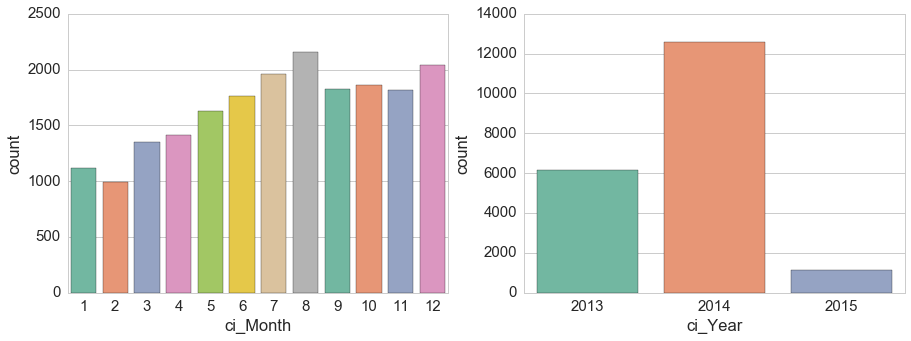

In [59]:
# Plot bookings by month and by year. There are differences across months and check in year -- can explore further.
fig, (axis1,axis2) = plt.subplots(1,2, figsize=(15,5))
sns.countplot('ci_Month', data=df1_bookings, ax=axis1, palette="Set2")
sns.countplot('ci_Year', data=df1_bookings,ax=axis2, palette="Set2")

In [60]:
# Number of bookings by check in year
df1.groupby('ci_Year')['is_booking'].sum()

ci_Year
2013     6173.0
2014    12586.0
2015     1158.0
2016        0.0
Name: is_booking, dtype: float64

In [61]:
# Number of bookings by check in month
df1.groupby('ci_Month')['is_booking'].sum()

ci_Month
1     1121.0
2      994.0
3     1351.0
4     1412.0
5     1624.0
6     1762.0
7     1957.0
8     2158.0
9     1828.0
10    1857.0
11    1814.0
12    2039.0
Name: is_booking, dtype: float64

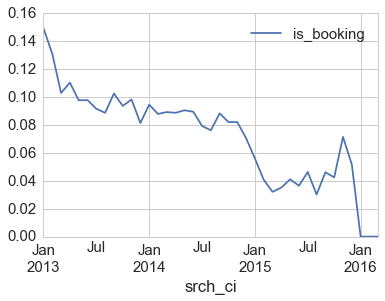

In [62]:
#Plot booking rate by check in date - percentage of all people who search hotels how many booked
df1[['is_booking']].resample('M').mean().plot()

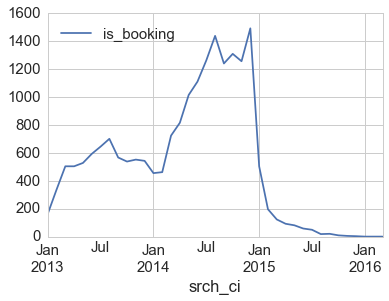

In [63]:
# Plot the total number of people who booked out of those who searched by check in date
df1[['is_booking']].resample('M').sum().plot()

In [64]:
# Reindex to date_time column
df1.set_index('date_time', inplace=True)

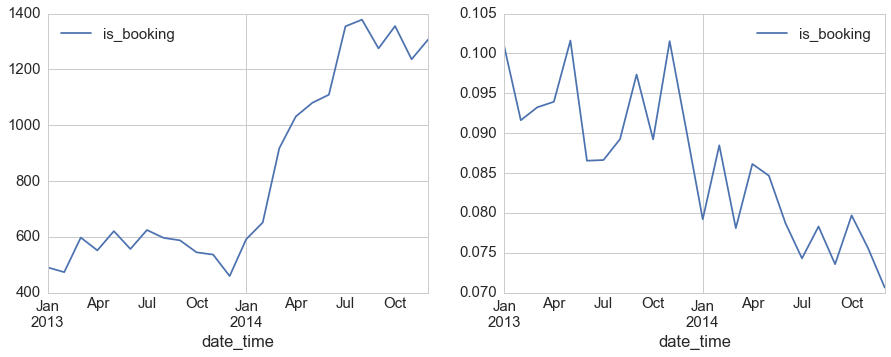

In [65]:
# Plot bookings and booking rate by search date
fig1= plt.figure(figsize=(15,5))
ax11= fig1.add_subplot(121)
df1[['is_booking']].resample('M').sum().plot(ax=ax11)
ax22= fig1.add_subplot(122)
df1[['is_booking']].resample('M').mean().plot(ax=ax22)

In [66]:
df1.index.dtype

dtype('<M8[ns]')

In [67]:
# Subset data for the most searched/booked hotel cluster
tophotel=df1[df1.hotel_cluster==91.0]

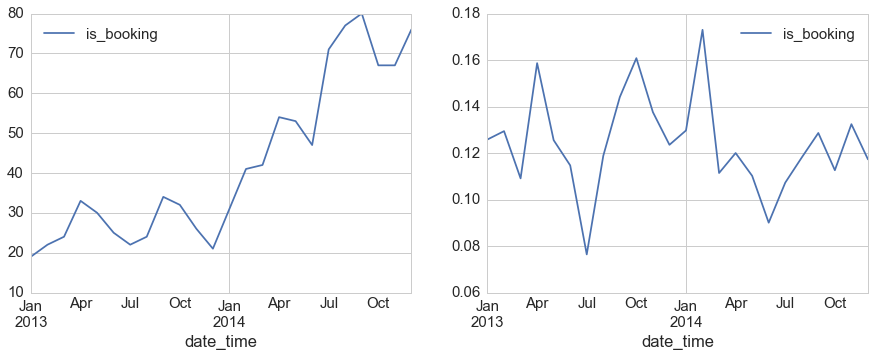

In [68]:
# Plot booking rate and number of bookings for the top hotel cluster by search date
fig1= plt.figure(figsize=(15,5))
ax11= fig1.add_subplot(121)
tophotel[['is_booking']].resample('M').sum().plot(ax=ax11)
ax22= fig1.add_subplot(122)
tophotel[['is_booking']].resample('M').mean().plot(ax=ax22)

## Model for is_mobile

In [ ]:
# Look into relationship between searches via mobile device and bookings

In [69]:
# check for means groupped by is_mobile; there is difference in means for origin to destination distance variable and bookings
df1.groupby('is_mobile').mean()

,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,is_package,channel,srch_children_cnt,srch_destination_id,srch_destination_type_id,is_booking,hotel_continent,hotel_country,hotel_market,hotel_cluster,ci_Year,ci_Month
is_mobile,,,,,,,,,,,,,,,,,
0,2.898524,87.905020,312.434554,28144.513572,2018.581479,0.236426,6.068914,0.344374,14411.855316,2.637953,0.085648,2.912139,74.652833,619.885756,49.706421,2013.841754,7.114593
1,2.930599,87.041135,307.867253,27882.492378,1651.085937,0.293912,5.618736,0.401041,14159.832507,2.535644,0.062038,2.760915,69.758116,628.571242,50.312654,2013.885752,7.192168


In [70]:

df1.is_booking.mean()

0.08243620785993667

In [71]:
# How many searches are made trhough mobile device - approx. 13%
df1.is_mobile.mean()

0.13603609196829536

In [72]:
# Create a StandardScaler instance to normalize
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [74]:
# First, I will try a basic model with is_booking as outcome and is_mobile as predictor
# Do train_test_split
from sklearn.cross_validation import train_test_split
X = df1[['is_mobile']]
y = df1['is_booking']

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, random_state=1)

In [75]:
# Fit standard scaler on the training data only
scaler.fit(X_train)
print 'Means: ', scaler.mean_
print 'Standard Deviations: ', scaler.scale_

Means:  [ 0.13634984]
Standard Deviations:  [ 0.34315967]


In [76]:
# Apply the scaling to training data
X_train_scaled = scaler.transform(X_train)

In [77]:
 # Apply the scaling to testing data
X_test_scaled = scaler.transform(X_test)

In [78]:
# Fit a logistic model because I am predicting a binary variable (click=0, booking=1)
# Looks like there is a negative relationship with the outcome if user is searching via mobile device
from sklearn import linear_model
logit_simple = linear_model.LogisticRegression(C=1e9).fit(X_train_scaled, y_train)

print logit_simple.coef_

[[-0.12107299]]


In [79]:
print metrics.accuracy_score(y_train, logit_simple.predict(X_train_scaled))
print metrics.accuracy_score(y_test, logit_simple.predict(X_test_scaled))

0.917495847199
0.917767623589


In [80]:
y_pred = logit_simple.predict(X_test_scaled)
y_pred_proba = logit_simple.predict_proba(X_test_scaled)

In [82]:
y_test.describe()

count    60402.000000
mean         0.082232
std          0.274721
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: is_booking, dtype: float64

In [83]:
# model is just predictig that all mobile searches will result with a click
metrics.confusion_matrix(y_test, y_pred)

array([[55435,     0],
       [ 4967,     0]])

In [375]:
# Build more complicated model adding origin to destination distance and is_package variable
X = df1[['orig_destination_distance','is_package','is_mobile']]
y = df1['is_booking']

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, random_state=5)

In [376]:
scaler.fit(X_train)
print 'Means: ', scaler.mean_
print 'Standard Deviations: ', scaler.scale_

Means:  [  1.97287463e+03   2.44328184e-01   1.36167723e-01]
Standard Deviations:  [  2.23106648e+03   4.29688169e-01   3.42966579e-01]


In [377]:
# Apply scaling to training and testing data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [378]:
# Fit a new logistic regression model
logit = linear_model.LogisticRegression().fit(X_train_scaled,y_train)

print logit.coef_

[[-0.14103022 -0.34507872 -0.10665983]]


In [371]:
print metrics.accuracy_score(y_train, logit.predict(X_train_scaled))
print metrics.accuracy_score(y_test, logit.predict(X_test_scaled))

0.917981490373
0.916310718188


In [379]:
y_pred = logit.predict(X_test_scaled)
y_pred_proba = logit.predict_proba(X_test_scaled)

In [380]:
y_pred_proba[:5]

array([[ 0.91931317,  0.08068683],
       [ 0.92159552,  0.07840448],
       [ 0.91619626,  0.08380374],
       [ 0.89828791,  0.10171209],
       [ 0.9145413 ,  0.0854587 ]])

In [381]:
# Again model is predicting all mobile searches will result in a click
metrics.confusion_matrix(y_test, y_pred)

array([[55347,     0],
       [ 5055,     0]])

In [382]:
# AUC score improved slightly from previous run (from approx. 0.56 to 0.595) with the addition of new variables.
# I tested running the model with and without is_mobile variable. Although the is_mobile variable does not have a sizable
# impact on bookings, it did make small difference predicting the booking outcome.
metrics.roc_auc_score(y_test, y_pred_proba[:,1])

0.59589043798609886

In [383]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_proba[:,1])

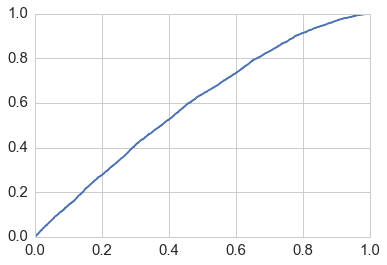

In [384]:
# AUC curve plot improved a little.
plt.figure()
plt.plot(fpr, tpr)

## Predicting Hotel Cluster

### Logistic regression

In [117]:
# Since the outcome is class (hotel cluste), it is appropriate to use logistic regression.
# I fit logisitc regression on both df1 and df2 datasets. 
df1.columns

Index([u'posa_continent', u'user_location_country', u'user_location_region',
       u'user_location_city', u'orig_destination_distance', u'is_mobile',
       u'is_package', u'channel', u'srch_children_cnt', u'srch_destination_id',
       u'srch_destination_type_id', u'is_booking', u'hotel_continent',
       u'hotel_country', u'hotel_market', u'hotel_cluster', u'ci_Year',
       u'ci_Month'],
      dtype='object')

In [312]:
# Check for variable correlations with the hotel cluster. 
# Below coefficients do not look like there is a linear relationship with any of the variables.
# But I will still go ahead and try out the logistic model.
df1.corr()['hotel_cluster']

user_location_country       -0.017823
user_location_region         0.009491
user_location_city          -0.002622
orig_destination_distance    0.007690
is_mobile                    0.007132
is_package                   0.044908
channel                      0.002850
srch_children_cnt            0.011556
srch_destination_id         -0.016413
srch_destination_type_id    -0.034978
is_booking                  -0.026262
hotel_continent              0.002333
hotel_market                 0.024345
hotel_cluster                1.000000
ci_Year                      0.008727
ci_Month                     0.001544
hotel_country_0.0           -0.033132
hotel_country_1.0            0.002803
hotel_country_2.0           -0.000392
hotel_country_3.0            0.001950
hotel_country_4.0            0.000088
hotel_country_5.0            0.015099
hotel_country_7.0           -0.011074
hotel_country_8.0            0.073188
hotel_country_9.0            0.003143
hotel_country_10.0           0.002578
hotel_countr

In [118]:
# I started fitting the model with only numeric features such as origin to destination distance, is_package, is_mobile, 
# year, month and recorded the results in the end of this section. After not having any luck with
# the existing numeric features, I decided to create dummies for hotel_country variable.
df1 = pd.get_dummies(df1,columns=['hotel_country'])

In [119]:
df1 = pd.get_dummies(df1,columns=['posa_continent'])

In [120]:
# On several runs of the model, I used the below list to exclude features rather 
# than including each of 198 hotel countries into the features.
not_included = ['hotel_cluster','posa_continent','user_location_country','user_location_region',
                'user_location_city','channel','srch_destination_id','srch_destination_type_id',
              'hotel_continent', 'hotel_market','is_booking','is_mobile']

In [121]:
# This model had the highest accuracy score in testing set.
X = df1[['orig_destination_distance','srch_children_cnt','ci_Year','ci_Month','is_package','is_mobile','hotel_country_50.0',
        'hotel_country_198.0','hotel_country_8.0', 'hotel_country_105.0','hotel_country_70.0', 
        'posa_continent_2','posa_continent_3','posa_continent_4']]
y = df1['hotel_cluster']

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, random_state=1)

In [122]:
logit = linear_model.LogisticRegression(C=1e9).fit(X_train,y_train)

In [123]:
y_pred = logit.predict(X_test)
y_pred_proba = logit.predict_proba(X_test)
print metrics.classification_report(y_test, y_pred)

             precision    recall  f1-score   support

        0.0       0.05      0.04      0.05       734
        1.0       0.06      0.40      0.10       830
        2.0       0.00      0.00      0.00       600
        3.0       0.00      0.00      0.00       280
        4.0       0.00      0.00      0.00       661
        5.0       0.00      0.00      0.00       858
        6.0       0.00      0.00      0.00       633
        7.0       0.00      0.00      0.00       455
        8.0       0.09      0.37      0.15       471
        9.0       0.00      0.00      0.00       797
       10.0       0.00      0.00      0.00       668
       11.0       0.00      0.00      0.00       415
       12.0       0.00      0.00      0.00       190
       13.0       0.00      0.00      0.00       662
       14.0       0.00      0.00      0.00       293
       15.0       0.00      0.00      0.00       470
       16.0       0.00      0.00      0.00       864
       17.0       0.00      0.00      0.00   

c:\Users\korol_000\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [124]:
print metrics.accuracy_score(y_train, logit.predict(X_train))
print metrics.accuracy_score(y_test, logit.predict(X_test))
print logit.coef_[:10]

0.0714723266171
0.0708089136121
[[  9.32050597e-05   2.67481860e-01  -2.94919091e-03  -2.29925771e-02
    1.17962638e+00   1.50667715e-01   9.16424290e-01  -3.25235774e-01
    2.09938482e-01  -2.45629875e-01  -1.84785164e-01  -1.10760516e-02
    4.22538171e-01  -6.68076888e-02]
 [  6.37158951e-05  -3.57748402e-01  -3.77032441e-03  -1.43694346e-02
    1.06252044e+00  -6.68335316e-02   3.81506113e+00  -3.62787763e-01
   -5.87492011e-01  -2.29989022e-01  -1.80831898e-01  -1.50206225e-02
   -3.13384292e-02   1.48201693e-01]
 [  3.32738613e-05  -5.27730293e-02  -1.85933171e-03  -9.45105608e-03
   -1.89166638e-01  -1.14190201e-01  -1.04311855e+00  -1.94645546e-02
   -2.66819558e-01   4.81987427e-02   2.37502167e-01  -2.26915833e-02
   -4.41871126e-01   1.03838527e-01]
 [  3.13016295e-05   1.15676286e-01  -2.21006676e-03  -1.23848166e-02
   -1.32940723e-01   4.31371227e-02  -7.90563602e-01  -3.41585065e-01
   -7.41928802e-01   1.78556762e-01  -9.80148933e-02   8.51644702e-02
   -4.51141384e-0

In [225]:
# After fitting a logistic model on only numeric features, I decided to try stochastic gradient descent.
# However, accuracy scores were low, so I switched back to logistic regression. 
logloss = linear_model.SGDClassifier(loss='log', penalty='l1', alpha=1).fit(X_train, y_train)

In [226]:
print metrics.accuracy_score(y_train, logloss.predict(X_train))
print metrics.accuracy_score(y_test, logloss.predict(X_test))
print logloss.coef_[:10]


0.0185547090648
0.0202215928852
[[ -408.54725776     0.             0.         ...,     0.             0.
      0.        ]
 [-4235.23679967     0.             0.         ...,     0.             0.
      0.        ]
 [  135.28299055     0.             0.         ...,     0.             0.
      0.        ]
 ..., 
 [-1038.86955165     0.             0.         ...,     0.             0.
      0.        ]
 [-3162.37308637     0.             0.         ...,     0.             0.
      0.        ]
 [-1442.26432366     0.             0.         ...,     0.             0.
      0.        ]]


### Records of accuracy scores for different feature combinations in the first dataframe

In [ ]:
# X = df1[['ci_Year','srch_children_cnt', 'orig_destination_distance', 'ci_Month']]
# print metrics.accuracy_score(y_train, logloss.predict(X_train))
# print metrics.accuracy_score(y_test, logloss.predict(X_test))
# 0.026404990615
# 0.0255378347493

In [ ]:
# X = df1[['ci_Year', 'orig_destination_distance', 'ci_Month']]
# print metrics.accuracy_score(y_train, logloss.predict(X_train))
# print metrics.accuracy_score(y_test, logloss.predict(X_test))
# 0.0167660373192
# 0.0171411536742

In [ ]:
# X = df1[['ci_Year', 'orig_destination_distance', 'ci_Month', 'srch_children_cnt', 'is_package', 'is_booking']]
# print metrics.accuracy_score(y_train, logloss.predict(X_train))
# print metrics.accuracy_score(y_test, logloss.predict(X_test))
# 0.0111460748592
# 0.0106987297329

In [ ]:
# X = df1[['ci_Year', 'orig_destination_distance', 'ci_Month', 'srch_children_cnt', 'is_package']]
# print metrics.accuracy_score(y_train, logloss.predict(X_train))
# print metrics.accuracy_score(y_test, logloss.predict(X_test))
# 0.0300264988407
# 0.0300591245591

In [ ]:
# X = df1[['ci_Year', 'orig_destination_distance', 'ci_Month', 'srch_children_cnt', 'is_package','is_mobile']]
# print metrics.accuracy_score(y_train, logloss.predict(X_train))
# print metrics.accuracy_score(y_test, logloss.predict(X_test))
# 0.0342718339406
# 0.0336860933075

In [ ]:
# not_included = ['hotel_cluster','posa_continent','user_location_country','user_location_region',
                #'user_location_city','channel','srch_destination_id','srch_destination_type_id',
               # 'hotel_continent', 'hotel_market']
# print metrics.accuracy_score(y_train, logloss.predict(X_train))
# print metrics.accuracy_score(y_test, logloss.predict(X_test))
# 0.0324886827868
# 0.0326095957338

In [ ]:
# not_included = ['hotel_cluster','posa_continent','user_location_country','user_location_region',
                #'user_location_city','channel','srch_destination_id','srch_destination_type_id',
               #'hotel_continent', 'hotel_market','is_booking']
# print metrics.accuracy_score(y_train, logloss.predict(X_train))
# print metrics.accuracy_score(y_test, logloss.predict(X_test))
# 0.0329910566413
# 0.0322949272122

In [ ]:
# not_included = ['hotel_cluster','posa_continent','user_location_country','user_location_region',
               # 'user_location_city','channel','srch_destination_id','srch_destination_type_id',
              # 'hotel_continent', 'hotel_market','is_booking','is_mobile']
# print metrics.accuracy_score(y_train, logloss.predict(X_train))
# print metrics.accuracy_score(y_test, logloss.predict(X_test))
# 0.0229435795517
# 0.024262599162

In [ ]:
# not_included = ['hotel_cluster','posa_continent','user_location_country','user_location_region',
               # 'user_location_city','channel','srch_destination_id','srch_destination_type_id',
              # 'hotel_continent', 'hotel_market','is_booking','is_package']
# print metrics.accuracy_score(y_train, logloss.predict(X_train))
# print metrics.accuracy_score(y_test, logloss.predict(X_test))
# 0.0185547090648
# 0.0202215928852

In [ ]:
# X = df1[['orig_destination_distance','srch_children_cnt','ci_Year','ci_Month','is_package']]
# print metrics.accuracy_score(y_train, logit.predict(X_train))
# print metrics.accuracy_score(y_test, logit.predict(X_test))
# print logit.coef_[:10]
# 0.0553770564204
# 0.0551497987778

In [ ]:
# X = df1[['orig_destination_distance','srch_children_cnt','ci_Year','ci_Month','is_package', 'is_mobile']]
# print metrics.accuracy_score(y_train, logit.predict(X_train))
# print metrics.accuracy_score(y_test, logit.predict(X_test))
# print logit.coef_[:10]
# 0.0555978800927
# 0.0552657292857

In [ ]:
# X = df1[['orig_destination_distance','srch_children_cnt','ci_Year','ci_Month','is_package','is_mobile','hotel_country_50.0']]
# print metrics.accuracy_score(y_train, logit.predict(X_train))
# print metrics.accuracy_score(y_test, logit.predict(X_test))
# print logit.coef_[:10]
# 0.0645688417798
# 0.0643083089051

In [ ]:
# X = df1[['orig_destination_distance','srch_children_cnt','ci_Year','ci_Month','is_package','is_mobile','hotel_country_50.0',
#      'hotel_country_198.0','hotel_country_8.0','hotel_country_105.0','hotel_country_105.0','hotel_country_70.0']]
# print metrics.accuracy_score(y_train, logit.predict(X_train))
# print metrics.accuracy_score(y_test, logit.predict(X_test))
# print logit.coef_[:10]
# 0.0705476427073
# 0.0691111442341

In [ ]:
# X = df1[['orig_destination_distance','srch_children_cnt','ci_Year','ci_Month','is_package','is_mobile','hotel_country_50.0',
#        'hotel_country_198.0','hotel_country_8.0','hotel_country_105.0','hotel_country_105.0','hotel_country_70.0', 
#        'posa_continent_2','posa_continent_3','posa_continent_4']]
# print metrics.accuracy_score(y_train, logit.predict(X_train))
# print metrics.accuracy_score(y_test, logit.predict(X_test))
# print logit.coef_[:10]
# 0.0710886607044
# 0.0703366953181

### Logistic regression on second dataframe

In [102]:
# Second dataframe has two additional columns for length of stay and booking window
df2.columns

Index([u'date_time', u'posa_continent', u'user_location_country',
       u'user_location_region', u'user_location_city', u'is_mobile',
       u'is_package', u'channel', u'srch_ci', u'srch_co', u'srch_children_cnt',
       u'srch_destination_id', u'srch_destination_type_id', u'is_booking',
       u'hotel_continent', u'hotel_country', u'hotel_market', u'hotel_cluster',
       u'bw', u'LOS'],
      dtype='object')

In [282]:
X = df2[['bw','LOS','is_mobile', 'is_package']]
y = df2['hotel_cluster']
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, random_state=5)

In [283]:
# I used stochastic gradient descent model and l1 type regularization
logloss = linear_model.SGDClassifier(loss='log', penalty='l1', alpha=1).fit(X_train, y_train)

In [284]:
# Although accuracy score was also very low, the l1 regularization shows higher coefficient for the booking window variable
# compared to the other variables in the model.
logloss.coef_

array([[ -6.18222778e+01,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00],
       [ -5.30920704e+01,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00],
       [ -2.24548836e-02,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00],
       [ -3.90798790e-02,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00],
       [ -3.02565178e-02,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00],
       [ -1.09579003e+01,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00],
       [ -2.02789799e+01,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00],
       [ -3.33091810e-02,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00],
       [ -2.56808575e-02,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00],
       [ -1.03661261e+01,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00],
       [ -3.38402671e-02,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00],
       [ -6.77475392e

In [285]:
print metrics.accuracy_score(y_train, logloss.predict(X_train))
print metrics.accuracy_score(y_test, logloss.predict(X_test))

0.0178520797301
0.0177456911676


### Records of accuracy scores for different feature combinations in the second dataframe

In [ ]:
# X = df2[['bw','LOS','is_package']]
# print metrics.accuracy_score(y_train, logloss.predict(X_train))
# print metrics.accuracy_score(y_test, logloss.predict(X_test))

# 0.0177457540616
# 0.0185431308545

In [ ]:
# X = df2[['bw','LOS','is_mobile']]
#
# print metrics.accuracy_score(y_train, logloss.predict(X_train))
# print metrics.accuracy_score(y_test, logloss.predict(X_test))
# 0.0155448127251
# 0.0150131311735
#

In [ ]:
# X = df2[['bw','LOS','is_mobile', 'is_package']]
# print metrics.accuracy_score(y_train, logloss.predict(X_train))
# print metrics.accuracy_score(y_test, logloss.predict(X_test))
# 0.0153817800335
# 0.0150237637027


## Random Forest first dataframe

In [125]:
# After getting very low accuracy scores with the stochastic gradient descent and logistic regression models,
# I decided to try random forest.
df1.columns

Index([u'user_location_country', u'user_location_region',
       u'user_location_city', u'orig_destination_distance', u'is_mobile',
       u'is_package', u'channel', u'srch_children_cnt', u'srch_destination_id',
       u'srch_destination_type_id',
       ...
       u'hotel_country_207.0', u'hotel_country_208.0', u'hotel_country_210.0',
       u'hotel_country_211.0', u'hotel_country_212.0', u'posa_continent_0',
       u'posa_continent_1', u'posa_continent_2', u'posa_continent_3',
       u'posa_continent_4'],
      dtype='object', length=200)

In [126]:
from sklearn import ensemble

In [127]:
target = 'hotel_cluster'

In [219]:
# Random forest model on the whole first dataframe to get baseline accuracy, which turned up to be 0.115 on testing set.
# It was an improvement from the logistic regression results, but still low.
X = df1.drop(target,axis=1)
y = df1[target]

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.4, random_state=42)

In [214]:
# Random forest model on the second dataframe. The accuracy score- 0.34 was even lower than the baseline accuracy.
# I went back to test different feature variations of the first dataframe. 
X = df2[['bw','LOS','is_mobile', 'is_package']]
y = df2['hotel_cluster']
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, random_state=5)

In [223]:
df1['2014'][:1]

,user_location_country,user_location_region,user_location_city,orig_destination_distance,is_mobile,is_package,channel,srch_children_cnt,srch_destination_id,srch_destination_type_id,...,hotel_country_207.0,hotel_country_208.0,hotel_country_210.0,hotel_country_211.0,hotel_country_212.0,posa_continent_0,posa_continent_1,posa_continent_2,posa_continent_3,posa_continent_4
date_time,,,,,,,,,,,,,,,,,,,,,
2014-07-23 08:41:08,66,442,47956,1192.1126,0,1,9,0.0,8287.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [292]:
# After rerunning the model with various feature combinations, 
# I realized that variables related to hotel location yielded the highest accuracy score.

features = ['hotel_continent','hotel_market','srch_destination_id'] + \
            filter(lambda x: x.startswith('hotel_country_'), df1.columns)

X = df1[features]
y = df1['hotel_cluster']

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.4, random_state=3) 

In [293]:
# Instantiate model
rf = ensemble.RandomForestClassifier(n_estimators=50, min_samples_leaf=5).fit(X_train,y_train)


In [315]:
# Evaluate model on train set
print "Accuracy: %0.3f" % rf.score(X_train, y_train)

# Evaluate model on test set
print "Accuracy: %0.3f" % rf.score(X_test, y_test)

Accuracy: 0.209
Accuracy: 0.160


In [316]:
cross_validation.cross_val_score(rf, X_test, y_test, cv=3)

array([ 0.14930696,  0.14462656,  0.14680382])

In [132]:
# Tune the model
# Set list of values to grid search over
# Despite trying to update the model with the n_estimators=200, I kept receiving the memory error.
n = [1, 2, 3, 10, 20, 30, 100, 200, 300]
params = {'n_estimators': n}

# Perform grid search using list of values
gs = grid_search.GridSearchCV(
    estimator=ensemble.RandomForestClassifier(min_samples_leaf=30),
    param_grid=params)
gs.fit(X_train, y_train)

# Get best value to use
print "Best Params:"
print gs.best_params_

Best Params:
{'n_estimators': 200}


### Records of accuracy scores for different feature combinations

In [ ]:
# X = df1['2014'][['hotel_continent','hotel_market','hotel_country_50.0',
    #    'hotel_country_198.0','hotel_country_8.0', 'hotel_country_105.0','hotel_country_70.0',
     #   'srch_destination_id']]
# print "Accuracy: %0.3f" % rf.score(X_train, y_train)
# print "Accuracy: %0.3f" % rf.score(X_test, y_test) 
# Accuracy: 0.193
# Accuracy: 0.152

In [ ]:
# X = df1[['orig_destination_distance','srch_children_cnt','ci_Year','ci_Month','is_package','is_mobile','hotel_country_50.0',
 #       'hotel_country_198.0','hotel_country_8.0', 'hotel_country_105.0','hotel_country_70.0', 
#   'posa_continent_2','posa_continent_3','posa_continent_4', 'user_location_country', 'user_location_region', 
#         'srch_destination_type_id']]
# print "Accuracy: %0.3f" % rf.score(X_train, y_train)
# print "Accuracy: %0.3f" % rf.score(X_test, y_test)
# Accuracy: 0.134
# Accuracy: 0.087

In [ ]:
# X = df1.drop(target,axis=1)
# print "Accuracy: %0.3f" % rf.score(X_train, y_train)
# print "Accuracy: %0.3f" % rf.score(X_test, y_test)
# Accuracy: 0.138
# Accuracy: 0.115

In [ ]:
# X = df2[['bw','LOS','is_mobile', 'is_package']]
# print "Accuracy: %0.3f" % rf.score(X_train, y_train)
# print "Accuracy: %0.3f" % rf.score(X_test, y_test)
# Accuracy: 0.060
# Accuracy: 0.034

## Summary of Feature Importances

In [304]:
y_pred = rf.predict(X_test)

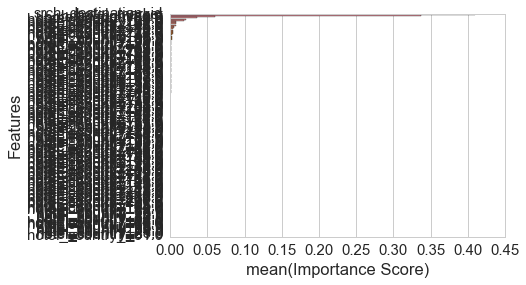

In [300]:
# Plot importances for all features
features = X.columns
feature_importances = rf.feature_importances_

features_df = pd.DataFrame({'Features': features, 'Importance Score': feature_importances})
features_df.sort_values('Importance Score', inplace=True, ascending=False)

sns.barplot(y='Features', x='Importance Score', data=features_df)

In [301]:
def combine_dummies(dummy_prefixes):
    for p in dummy_prefixes:
        sub_keys = filter(lambda x: x.startswith(p), feature_dict)
        sub_keys_sum = sum([feature_dict[x] for x in sub_keys])
        for k in sub_keys: feature_dict.pop(k)
        feature_dict[p] = sub_keys_sum
    return feature_dict

Accuracy: 0.160


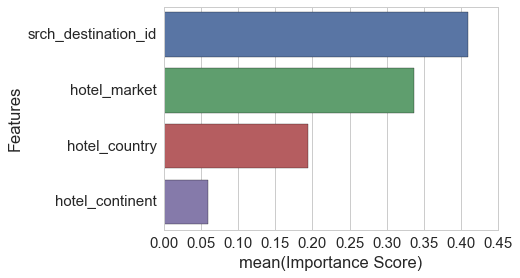

In [302]:
# Plot importances with dummy features combined
feature_names = X.columns
feature_importances = rf.feature_importances_
feature_dummy_prefixes = ['hotel_country']

feature_dict = dict(zip(feature_names, feature_importances))
feature_dict = combine_dummies(feature_dummy_prefixes)

features_df = pd.DataFrame(feature_dict.items(), columns=['Features', 'Importance Score'])
features_df.sort_values('Importance Score', inplace=True, ascending=False)

sns.barplot(y='Features', x='Importance Score', data=features_df)

# Evaluate accuracy of model on test set
print "Accuracy: %0.3f" % rf.score(X_test, y_test)



In [340]:
bookings = bookings[['srch_destination_id','hotel_cluster','is_booking']]

In [345]:
booking = bookings.groupby(['srch_destination_id','hotel_cluster']).sum()

In [346]:
booking = booking.reset_index()

In [366]:
booking.groupby('srch_destination_id')['hotel_cluster','is_booking'].head()

,hotel_cluster,is_booking
0,99.0,1.0
1,7.0,2.0
2,43.0,1.0
3,48.0,3.0
4,91.0,1.0
5,76.0,1.0
6,64.0,1.0
7,75.0,1.0
8,3.0,1.0
9,23.0,2.0


In [319]:
dd1 = dataframe.read_csv('test/test.csv/test.csv', blocksize=100000000)

In [320]:
with ProgressBar():
    data = dd1.sample(.1).compute()

[########################################] | 100% Completed | 16.3s


In [321]:
pd.DataFrame(data).head()

,id,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,...,srch_ci,srch_co,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,hotel_continent,hotel_country,hotel_market
402133,402133,2015-07-10 13:38:52,37,1,48,424,5957,NaN,135838,0.0,...,2015-07-12,2015-07-17,1.0,0.0,1.0,8823.0,1.0,3.0,0.0,1447.0
547478,547478,2015-01-17 12:52:13,30,4,195,548,8263,NaN,619224,0.0,...,2015-07-15,2015-07-20,2.0,0.0,1.0,20896.0,6.0,0.0,63.0,1258.0
663579,663579,2015-03-02 08:24:49,2,3,66,260,44144,NaN,1005027,1.0,...,2015-04-07,2015-04-12,2.0,0.0,1.0,12228.0,6.0,2.0,50.0,411.0
309635,309635,2015-09-20 15:33:50,40,3,66,403,34516,153.3662,1031427,0.0,...,2015-09-22,2015-09-23,4.0,0.0,1.0,26129.0,6.0,2.0,50.0,1250.0
800758,800758,2015-05-04 23:28:31,2,3,66,174,9351,806.7148,260677,0.0,...,2015-06-08,2015-06-10,1.0,0.0,1.0,8288.0,1.0,2.0,198.0,399.0


In [ ]:
ferq_clusters = train_df['hotel_cluster'].value_counts()[:5]

In [ ]:
top_clusters  = train_df.groupby(['srch_destination_id']).apply(get_top_clusters)